# Calour sample analysis notebook
This notebook uses the Chronic Fatigue Syndrome dataset from:

"Giloteaux, Ludovic, et al.

"Reduced diversity and altered composition of the gut microbiome in individuals with myalgic encephalomyelitis/chronic fatigue syndrome."

Microbiome 4.1 (2016): 30."

But can be used for any amplicon experiment. Just need to provide a biom table and a mapping file.

### NOTE: full Calour documentation can be found [here](http://biocore.github.io/calour/)

In [1]:
import calour as ca

/Users/amnon/miniconda3/envs/calour/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load the dataset
min_reads=1000 : throw away all samples with < 1000 reads

normalize=10000 : normalize total reads of each samples to 10000

(NOTE: this is not rarefaction - so samples with < 10000 reads will be streched to 10000 reads

Full function documentation [here](http://biocore.github.io/calour/generated/calour.io.read_amplicon.html#calour.io.read_amplicon)

In [2]:
dat = ca.read_amplicon('./cfs.biom','./cfs.map.txt',normalize=10000,min_reads=1000)

2019-05-15 10:39:50 WARNING These have metadata but do not have data - dropped (1): {'ERR1331814'}


## What do we have
NOTE: "features" means "bacteria" for amplicon data

In [4]:
print(dat)

AmpliconExperiment ("all.biom") with 87 samples, 2129 features


### Also lets see the sample_metadata (mapping file) columns
The sample metadata is stored as a pandas dataframe

In [5]:
print(dat.sample_metadata.columns)

Index(['Sample_Name_s', 'collection_date_s', 'environment_biome_s',
       'environmental_package_s', 'geographic_location_country_and_or_sea_s',
       'Pittsburgh', 'Energy_fatigue', 'sCD14ugml', 'Sex', 'IFABPpgml',
       'General_health', 'LBPugml', 'Social_functioning', 'Role_emotio0l',
       'LPSpgml', 'Subject', 'Emotio0l_well_being', 'Role_physical', 'Bell',
       'Physical_functioning', 'Pain', 'Age', 'BMI', '_sample_id',
       '_calour_original_abundance'],
      dtype='object')


# Remove low abundance bacteria
we remove all bacteria with sum of reads < 10 reads total over all samples.

A tutorial notebook dealing with data manipulation is located [here](http://biocore.github.io/calour/notebooks/microbiome_manipulation.html)

In [6]:
dat = dat.filter_abundance(10)

In [7]:
print(dat)

AmpliconExperiment ("all.biom") with 87 samples, 1100 features


# Cluster the bacteria

In [8]:
dat = dat.cluster_features()

# Sort the samples according to the sick/healthy column

In [9]:
dat = dat.sort_samples('Subject')

# And plot the data
## Keyboard shortcuts (when mouse hovers over the heatmap)
Shift+up arrow - zoom in bacteria

Shift+down arrow - zoom out bacteria

Shift+right arrow - zoom in samples

Shift+left arrow - zoom in samples

up/down arrow - scroll bacteria

left/right arrow - scroll samples

### For full information about keyboard shortcuts and the plot function, see [here](http://biocore.github.io/calour/generated/calour.heatmap.plot.html#calour.heatmap.plot)

### interactive heatmap inside the notebook
Can click on a row/column to get information,

<IPython.core.display.Javascript object>


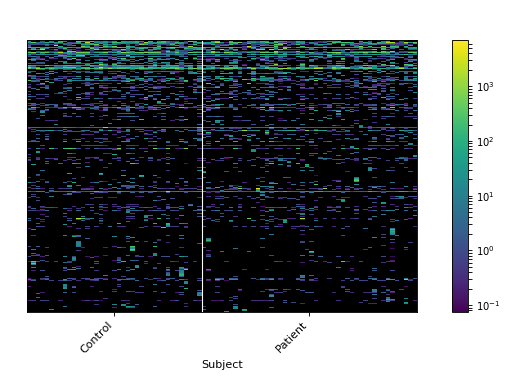

In [10]:
%matplotlib notebook
dat.plot(gui='jupyter', sample_field='Subject')

### Or alternatively plot in an external window

In [11]:
dat.plot(gui='qt5', sample_field='Subject')

# Get differentially abundant bacteria
between sick ('Patient') and healthy ('Control')

A tutorial notebook dealing with differential abundance can be found [here](http://biocore.github.io/calour/notebooks/microbiome_diff_abundance.html)

In [12]:
dd=dat.diff_abundance('Subject','Patient','Control', random_seed=2019)

In [13]:
print('there are %d bacteria significantly different between the two groups' % len(dd.feature_metadata))

there are 54 bacteria significantly different between the two groups


## Plotting the differentially abundant bacteria
We add the y-axis colorbar for the group in which the bacteria was high ('_calour_direction')

Note diff_abundance sorts the different bacteria according to the effect size

In [14]:
dd.plot(gui='qt5', sample_field='Subject', bary_fields=['_calour_direction'])

# Looking at dbbact annotations
A tutorial notebook for dbBact interfacing can be found [here](http://biocore.github.io/calour/notebooks/microbiome_databases.html)

You will need the [dbbact-calour](https://github.com/amnona/dbbact-calour) module to be installed in the same conda environment as calour in order to use these functions.
See Calour installation instructions [here](https://github.com/biocore/calour/blob/master/INSTALL.md)

## Enriched terms between the two groups

<IPython.core.display.Javascript object>


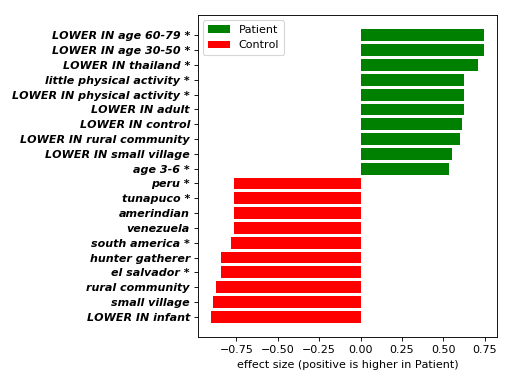

(<matplotlib.axes._subplots.AxesSubplot at 0x1a35783e80>,
 Experiment with 54 samples, 231 features)

In [15]:
%matplotlib notebook
dd.plot_diff_abundance_enrichment()

## Venn diagram for the "small village" term

In [16]:
db=ca.database._get_database_class('dbbact')

2019-05-15 10:20:39 WARNING No experiment found matching the details [['DataMD5', '99966db551ad04955c849cf018db31d9'], ['MapMD5', '88f1851e51864c653fd2a13d5c5d3fb8']]
2019-05-15 10:20:39 WARNING No matching experiment found in dbBact. Not ignoring any experiments


<IPython.core.display.Javascript object>


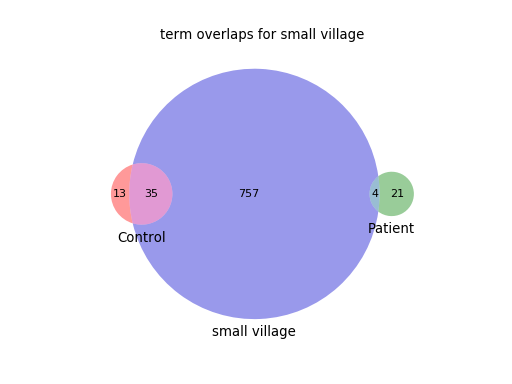

In [17]:
fig=db.plot_term_venn_all(['small village'], dd, ignore_exp=True)

## heatmap for annotations containing "small village"
NOTE: here columns are bacteria, rows are annotations (sorted by experiment, which is the y-axis colorbar)

In [18]:
# get the two groups of bacteria and their names (higher in patient, higher in control)
groups = dd.feature_metadata._calour_direction.unique()
g1features = []
g2features = []
g1name = groups[0]
g2name = groups[1]
for cfeature in dd.feature_metadata.index.values:
    if dd.feature_metadata._calour_direction[cfeature] == g1name:
        g1features.append(cfeature)
    if dd.feature_metadata._calour_direction[cfeature] == g2name:
        g2features.append(cfeature)

# plot the term heatmap
term_annotations = db.show_term_details('small village', dd, g1features, g2features, group1_name=g1name, group2_name=g2name, gui='qt5')

2019-05-15 10:20:42 WARNING Do you forget to normalize your data? It is required before running this function


## wordcloud for all the bacteria in the experiment

<IPython.core.display.Javascript object>


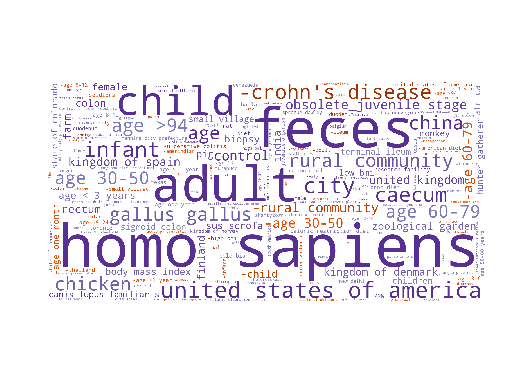

In [62]:
fig=db.draw_wordcloud(dat)

## and wordclouds for the bacteria higher in Patients/Controls

Control


<IPython.core.display.Javascript object>


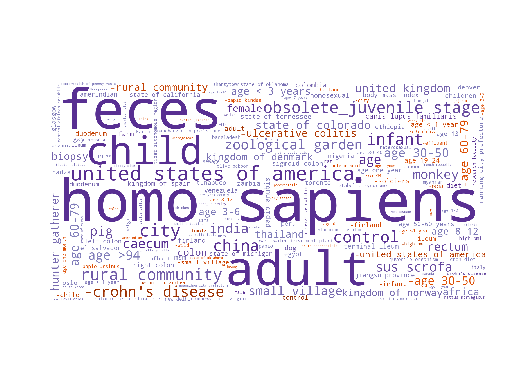

Patient


<IPython.core.display.Javascript object>


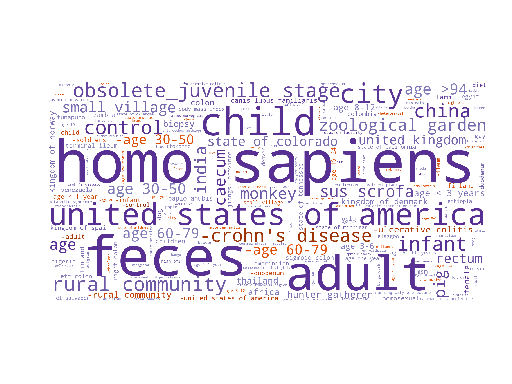

In [57]:
groups = dd.feature_metadata._calour_direction.unique()
g1features = []
g2features = []
g1name = groups[0]
g2name = groups[1]
for cfeature in dd.feature_metadata.index.values:
    if dd.feature_metadata._calour_direction[cfeature] == g1name:
        g1features.append(cfeature)
    if dd.feature_metadata._calour_direction[cfeature] == g2name:
        g2features.append(cfeature)

%matplotlib notebook
print(g1name)
fig=db.draw_wordcloud(dd, g1features)
print(g2name)
fig=db.draw_wordcloud(dd, g2features)